In [1]:
# installing Scipy
!pip install scipy==1.1.0

     |████████████████████████████████| 31.2 MB 1.2 MB/s 
  Attempting uninstall: scipy
    Found existing installation: scipy 1.4.1
    Uninstalling scipy-1.4.1:
      Successfully uninstalled scipy-1.4.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
pymc3 3.11.4 requires scipy>=1.2.0, but you have scipy 1.1.0 which is incompatible.
plotnine 0.6.0 requires scipy>=1.2.0, but you have scipy 1.1.0 which is incompatible.
jax 0.2.25 requires scipy>=1.2.1, but you have scipy 1.1.0 which is incompatible.
albumentations 0.1.12 requires imgaug<0.2.7,>=0.2.5, but you have imgaug 0.2.9 which is incompatible.


# Gesture Recognition
In this group project, you are going to build a CNN + RNN model and 3D Conv model that will be able to predict the 5 gestures correctly. Please import the following libraries to get started.

In [2]:
import numpy as np
import os
from scipy.misc import imread, imresize
import datetime
import os

In [3]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL
import glob
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from glob import glob

We set the random seed so that the results don't vary drastically.

In [4]:
np.random.seed(30)
import random as rn
rn.seed(30)
from tensorflow.keras import backend as K
import tensorflow as tf
#tf.set_random_seed(30)
tf.random.set_seed(30)

Mounting Google Drive

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Setting Root path 

In [25]:
#root_path = 'drive/MyDrive/app'
root_path = 'app'

Changing OS Dir to my Google drive path

In [22]:
os.chdir('/content/drive/MyDrive')
os.getcwd()

In this block, you read the folder names for training and validation. You also set the `batch_size` here. Note that you set the batch size in such a way that you are able to use the GPU in full capacity. You keep increasing the batch size until the machine throws an error.

In [58]:
train_doc = np.random.permutation(open(root_path+'/Project_data/train.csv').readlines())
val_doc = np.random.permutation(open(root_path+'/Project_data/val.csv').readlines())
batch_size = 32

Note here that a video is represented above in the generator as (number of images, height, width, number of channels). Take this into consideration while creating the model architecture.

In [29]:
curr_dt_time = datetime.datetime.now()
train_path = root_path+'/Project_data/train'
val_path = root_path+'/Project_data/val'
num_train_sequences = len(train_doc)
print('# training sequences =', num_train_sequences)
num_val_sequences = len(val_doc)
print('# validation sequences =', num_val_sequences)

# training sequences = 663
# validation sequences = 100


Retrieving Image list in 1st folder for checking

In [30]:
sample_image_list = os.listdir(train_path +'/'+ np.random.permutation(train_doc)[0].split(';')[0])

In [31]:
print(sample_image_list)

['WIN_20180907_15_46_43_Pro_00042.png', 'WIN_20180907_15_46_43_Pro_00046.png', 'WIN_20180907_15_46_43_Pro_00028.png', 'WIN_20180907_15_46_43_Pro_00040.png', 'WIN_20180907_15_46_43_Pro_00022.png', 'WIN_20180907_15_46_43_Pro_00036.png', 'WIN_20180907_15_46_43_Pro_00032.png', 'WIN_20180907_15_46_43_Pro_00038.png', 'WIN_20180907_15_46_43_Pro_00026.png', 'WIN_20180907_15_46_43_Pro_00024.png', 'WIN_20180907_15_46_43_Pro_00034.png', 'WIN_20180907_15_46_43_Pro_00030.png', 'WIN_20180907_15_46_43_Pro_00020.png', 'WIN_20180907_15_46_43_Pro_00044.png', 'WIN_20180907_15_46_43_Pro_00048.png', 'WIN_20180907_15_46_43_Pro_00074.png', 'WIN_20180907_15_46_43_Pro_00078.png', 'WIN_20180907_15_46_43_Pro_00054.png', 'WIN_20180907_15_46_43_Pro_00052.png', 'WIN_20180907_15_46_43_Pro_00058.png', 'WIN_20180907_15_46_43_Pro_00050.png', 'WIN_20180907_15_46_43_Pro_00064.png', 'WIN_20180907_15_46_43_Pro_00062.png', 'WIN_20180907_15_46_43_Pro_00056.png', 'WIN_20180907_15_46_43_Pro_00070.png', 'WIN_20180907_15_46_43_P

Retrieving 1st image from folder

In [32]:
sample_im_path = train_path +'/'+ train_doc[0].split(';')[0]
sample = imread(sample_im_path+'/'+os.listdir(sample_im_path)[0])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: DeprecationWarning:     `imread` is deprecated!
    `imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
    Use ``imageio.imread`` instead.
  


In [33]:
import matplotlib.pyplot as plt
%matplotlib inline

Plotting Sample Image

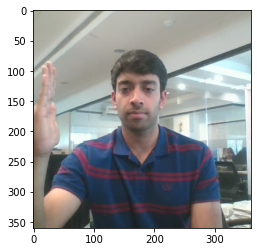

In [34]:
plt.imshow(sample)

Defining Image and Video parameters required for model definition

In [35]:
rows = 120   # X 
cols = 120   # Y 
channel = 3  # number of channels in images 3 for color(RGB)
frames= 10

Defining functions for Cropping and Resizing image as per parameters defined earlier

In [36]:
#data resizing - Resizing all the images, so we can have all the images in a specific size
def crop_resize_img(img):
    if img.shape[0] != img.shape[1]:
        img=img[0:120,10:150]
    resized_image = imresize(img, (rows,cols))
    return resized_image

Defining function to normalize image using Min Max

In [37]:
# normalize using min max 
def normalize_image(img):
    #using percentile for normalization for images, as min-max is giving better results.
    normalized_image= (img - np.min(img))/(np.max(img)- np.min(img))
    return normalized_image

## Generator
This is one of the most important part of the code. The overall structure of the generator has been given. In the generator, you are going to preprocess the images as you have images of 2 different dimensions as well as create a batch of video frames. You have to experiment with `img_idx`, `y`,`z` and normalization such that you get high accuracy.

In [38]:
def generator(source_path, folder_list, batch_size):
    print( 'Source path = ', source_path, '; batch size =', batch_size)
    img_idx = np.arange(0,30,3) #create a list of image numbers you want to use for a particular video
    while True:
        t = np.random.permutation(folder_list)
        num_batches = len(folder_list)//batch_size # calculate the number of batches
        for batch in range(num_batches): # we iterate over the number of batches
            batch_data = np.zeros((batch_size,frames,rows,cols,channel)) # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
            batch_labels = np.zeros((batch_size,5)) # batch_labels is the one hot representation of the output
            for folder in range(batch_size): # iterate over the batch_size
                imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) # read all the images in the folder
                for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
                    image = imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                    
                    #crop the images and resize them. Note that the images are of 2 different shape 
                    #and the conv3D will throw error if the inputs in a batch have different shapes
                    resized_image=crop_resize_img(image)
                    batch_data[folder,idx,:,:,0] = normalize_image(resized_image[:, : , 0]) #normalise and feed in the image
                    batch_data[folder,idx,:,:,1] = normalize_image(resized_image[:, : , 1])#normalise and feed in the image
                    batch_data[folder,idx,:,:,2] = normalize_image(resized_image[:, : , 2])#normalise and feed in the image
                    
                batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
            yield batch_data, batch_labels #you yield the batch_data and the batch_labels, remember what does yield do
        
        # write the code for the remaining data points which are left after full batches
        rem_image = len(folder_list)%batch_size
        batch += 1
        if(rem_image!=0):
            batch_data = np.zeros((rem_image,frames,rows,cols,channel)) # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
            batch_labels = np.zeros((rem_image,5)) # batch_labels is the one hot representation of the output
            for folder in range(rem_image): # iterate over the batch_size
                imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) # read all the images in the folder
                for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
                    image = imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                    
                    #crop the images and resize them. Note that the images are of 2 different shape 
                    #and the conv3D will throw error if the inputs in a batch have different shapes
                    resized_image=crop_resize_img(image)
                    batch_data[folder,idx,:,:,0] = normalize_image(resized_image[:, : , 0])
                    batch_data[folder,idx,:,:,1] = normalize_image(resized_image[:, : , 1])
                    batch_data[folder,idx,:,:,2] = normalize_image(resized_image[:, : , 2])
                    
                batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
            yield batch_data, batch_labels
        
     

Choosing number of Epochs to run for 1st model

In [56]:
num_epochs = 30 # choose the number of epochs
print ('# epochs =', num_epochs)

# epochs = 30


## Model
Here you make the model using different functionalities that Keras provides. Remember to use `Conv3D` and `MaxPooling3D` and not `Conv2D` and `Maxpooling2D` for a 3D convolution model. You would want to use `TimeDistributed` while building a Conv2D + RNN model. Also remember that the last layer is the softmax. Design the network in such a way that the model is able to give good accuracy on the least number of parameters so that it can fit in the memory of the webcam.

In [39]:


from keras.models import Sequential, Model
from keras.layers import Dense, GRU, Flatten, TimeDistributed, Flatten, BatchNormalization, Activation, Dropout,LSTM
from keras.layers.convolutional import Conv3D,Conv2D, MaxPooling3D,MaxPooling2D
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras import optimizers
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input




# Model 1

Defining 1st model using Time distributed Cov2D and GRU

In [59]:


#write your model here
nb_featuremap = [8,16,32,64]
nb_dense = [128,64,5]
nb_classes = 5
# Input
input_shape=(frames,rows,cols,channel)

model = Sequential()

model.add(TimeDistributed(Conv2D(nb_featuremap[0], (3, 3), strides=(2, 2),activation='relu', padding='same'), input_shape=input_shape))


model.add(TimeDistributed(Conv2D(nb_featuremap[1], (3,3),padding='same', activation='relu')))
model.add(TimeDistributed(MaxPooling2D((2, 2), strides=(2, 2))))

model.add(TimeDistributed(Conv2D(nb_featuremap[2], (3,3),padding='same', activation='relu')))
model.add(TimeDistributed(MaxPooling2D((2, 2), strides=(2, 2))))

model.add(TimeDistributed(Conv2D(nb_featuremap[3], (2,2),padding='same', activation='relu')))
model.add(TimeDistributed(MaxPooling2D((2, 2), strides=(2, 2))))

model.add(TimeDistributed(BatchNormalization()))
model.add(Dropout(0.25))

model.add(TimeDistributed(Flatten()))

model.add(Dense(nb_dense[0], activation='relu'))
model.add(Dropout(0.25))
model.add(Dense(nb_dense[1], activation='relu'))
model.add(Dropout(0.25))

## using GRU as the RNN model along with softmax as our last layer.
model.add(GRU(128, return_sequences=False))
model.add(Dense(nb_classes, activation='softmax')) # using Softmax as last layer



Now that you have written the model, the next step is to `compile` the model. When you print the `summary` of the model, you'll see the total number of parameters you have to train.

Let us create the `train_generator` and the `val_generator` which will be used in `.fit_generator`.

In [60]:


from tensorflow.keras.optimizers import Adam

optimiser =Adam(0.001) #write your optimizer
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary())

# creating the `train_generator` and the `val_generator` which will be used in `.fit_generator`
train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)



Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_41 (TimeDi  (None, 10, 60, 60, 8)    224       
 stributed)                                                      
                                                                 
 time_distributed_42 (TimeDi  (None, 10, 60, 60, 16)   1168      
 stributed)                                                      
                                                                 
 time_distributed_43 (TimeDi  (None, 10, 30, 30, 16)   0         
 stributed)                                                      
                                                                 
 time_distributed_44 (TimeDi  (None, 10, 30, 30, 32)   4640      
 stributed)                                                      
                                                                 
 time_distributed_45 (TimeDi  (None, 10, 15, 15, 32)  

Define Model checkpoint to be stored after every epoch and Learning Rate 

In [61]:
model_name = 'model_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)

LR = ReduceLROnPlateau(monitor='val_loss', factor=0.01, patience=5, cooldown=4, verbose=1,mode='auto',epsilon=0.0001) # write the REducelronplateau code here
callbacks_list = [checkpoint, LR]




The `steps_per_epoch` and `validation_steps` are used by `fit_generator` to decide the number of next() calls it need to make.

In [62]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

Let us now fit the model. This will start training the model and with the help of the checkpoints, you'll be able to save the model at the end of each epoch.


In [63]:
history_modelGRU = model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: DeprecationWarning:     `imread` is deprecated!
    `imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
    Use ``imageio.imread`` instead.
  del sys.path[0]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: DeprecationWarning:     `imresize` is deprecated!
    `imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
    Use ``skimage.transform.resize`` instead.
  """


Source path =  app/Project_data/train ; batch size = 32
Epoch 1/30
20/21 [===========================>..] - ETA: 1s - loss: 1.3358 - categorical_accuracy: 0.4094

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning:     `imread` is deprecated!
    `imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
    Use ``imageio.imread`` instead.


21/21 [==============================] - ETA: 0s - loss: 1.3295 - categorical_accuracy: 0.4118Source path =  app/Project_data/val ; batch size = 32

Epoch 00001: saving model to model_init_2022-01-2308_53_31.399787/model-00001-1.32947-0.41176-1.64521-0.23000.h5
21/21 [==============================] - 42s 2s/step - loss: 1.3295 - categorical_accuracy: 0.4118 - val_loss: 1.6452 - val_categorical_accuracy: 0.2300 - lr: 0.0010
Epoch 2/30
21/21 [==============================] - ETA: 0s - loss: 0.8763 - categorical_accuracy: 0.6682
Epoch 00002: saving model to model_init_2022-01-2308_53_31.399787/model-00002-0.87633-0.66817-1.59407-0.27000.h5
21/21 [==============================] - 39s 2s/step - loss: 0.8763 - categorical_accuracy: 0.6682 - val_loss: 1.5941 - val_categorical_accuracy: 0.2700 - lr: 0.0010
Epoch 3/30
21/21 [==============================] - ETA: 0s - loss: 0.6088 - categorical_accuracy: 0.7632
Epoch 00003: saving model to model_init_2022-01-2308_53_31.399787/model-00003-0.6

In [ ]:
# function to plot the training/validation accuracies/losses.

def plot(history):
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,4))
    axes[0].plot(history.history['loss'])   
    axes[0].plot(history.history['val_loss'])
    axes[0].legend(['loss','val_loss'])

    axes[1].plot(history.history['categorical_accuracy'])   
    axes[1].plot(history.history['val_categorical_accuracy'])
    axes[1].legend(['categorical_accuracy','val_categorical_accuracy'])
    

Plotting model to see Loss and Accuracy against Train and Validation Data

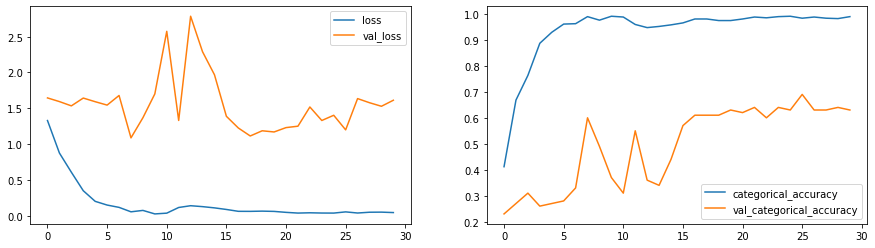

In [64]:
plot(history_modelGRU)

# Model 2

Defining 2nd model using Time distributed Cov2D and LSTM

In [41]:
#write your model here
nb_featuremap = [16,32,64,128,256]
nb_dense = [128,64,5]
nb_classes = 5
# Input
input_shape=(frames,rows,cols,channel)

model_LSTM = Sequential()

model_LSTM.add(TimeDistributed(Conv2D(nb_featuremap[0], (3, 3), strides=(2, 2),activation='relu', padding='same'), input_shape=input_shape))
model_LSTM.add(TimeDistributed(BatchNormalization()))
model_LSTM.add(TimeDistributed(MaxPooling2D((2, 2), strides=(2, 2))))

model_LSTM.add(TimeDistributed(Conv2D(nb_featuremap[1], (3,3),padding='same', activation='relu')))
model_LSTM.add(TimeDistributed(BatchNormalization()))
model_LSTM.add(TimeDistributed(MaxPooling2D((2, 2), strides=(2, 2))))

model_LSTM.add(TimeDistributed(Conv2D(nb_featuremap[2], (3,3),padding='same', activation='relu')))
model_LSTM.add(TimeDistributed(BatchNormalization()))
model_LSTM.add(TimeDistributed(MaxPooling2D((2, 2), strides=(2, 2))))

model_LSTM.add(TimeDistributed(Conv2D(nb_featuremap[3], (2,2),padding='same', activation='relu')))
model_LSTM.add(TimeDistributed(BatchNormalization()))
model_LSTM.add(TimeDistributed(MaxPooling2D((2, 2), strides=(2, 2))))

model_LSTM.add(TimeDistributed(Conv2D(nb_featuremap[4], (2,2),padding='same', activation='relu')))
model_LSTM.add(TimeDistributed(BatchNormalization()))
model_LSTM.add(TimeDistributed(MaxPooling2D((2, 2), strides=(2, 2))))

model_LSTM.add(Dropout(0.25))

model_LSTM.add(TimeDistributed(Flatten()))

## using LSTM as the RNN model along with softmax as our last layer.
model_LSTM.add(LSTM(64))
model_LSTM.add(Dense(nb_dense[0], activation='relu'))
model_LSTM.add(Dropout(0.25))
model_LSTM.add(Dense(nb_dense[1], activation='relu'))
model_LSTM.add(Dropout(0.25))

model_LSTM.add(Dense(nb_classes, activation='softmax')) # using Softmax as last layer

from tensorflow.keras.optimizers import Adam

optimiser =Adam(0.001) #write your optimizer
model_LSTM.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model_LSTM.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed (TimeDistr  (None, 10, 60, 60, 16)   448       
 ibuted)                                                         
                                                                 
 time_distributed_1 (TimeDis  (None, 10, 60, 60, 16)   64        
 tributed)                                                       
                                                                 
 time_distributed_2 (TimeDis  (None, 10, 30, 30, 16)   0         
 tributed)                                                       
                                                                 
 time_distributed_3 (TimeDis  (None, 10, 30, 30, 32)   4640      
 tributed)                                                       
                                                                 
 time_distributed_4 (TimeDis  (None, 10, 30, 30, 32)   1

The steps_per_epoch and validation_steps are used by fit_generator to decide the number of next() calls it need to make.

In [42]:
# creating the `train_generator` and the `val_generator` which will be used in `.fit_generator`
batch_size = 32
train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

num_epochs = 20

Let us now fit the model. This will start training the model and with the help of the checkpoints, you'll be able to save the model at the end of each epoch

In [44]:
history_modelLSTM = model_LSTM.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: DeprecationWarning:     `imread` is deprecated!
    `imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
    Use ``imageio.imread`` instead.
  del sys.path[0]


Source path =  app/Project_data/train ; batch size = 32


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: DeprecationWarning:     `imresize` is deprecated!
    `imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
    Use ``skimage.transform.resize`` instead.
  """


Epoch 1/20
20/21 [===========================>..] - ETA: 50s - loss: 1.5509 - categorical_accuracy: 0.2844 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning:     `imread` is deprecated!
    `imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
    Use ``imageio.imread`` instead.


21/21 [==============================] - ETA: 0s - loss: 1.5512 - categorical_accuracy: 0.2851 Source path =  app/Project_data/val ; batch size = 32

Epoch 00001: saving model to model_init_2022-01-2308_53_31.399787/model-00001-1.55121-0.28507-1.60847-0.21000.h5
21/21 [==============================] - 1157s 57s/step - loss: 1.5512 - categorical_accuracy: 0.2851 - val_loss: 1.6085 - val_categorical_accuracy: 0.2100 - lr: 0.0010
Epoch 2/20
21/21 [==============================] - ETA: 0s - loss: 1.3159 - categorical_accuracy: 0.4329
Epoch 00002: saving model to model_init_2022-01-2308_53_31.399787/model-00002-1.31593-0.43288-1.72397-0.20000.h5
21/21 [==============================] - 38s 2s/step - loss: 1.3159 - categorical_accuracy: 0.4329 - val_loss: 1.7240 - val_categorical_accuracy: 0.2000 - lr: 0.0010
Epoch 3/20
21/21 [==============================] - ETA: 0s - loss: 1.0869 - categorical_accuracy: 0.5611
Epoch 00003: saving model to model_init_2022-01-2308_53_31.399787/model-00003

Plotting LSTM model

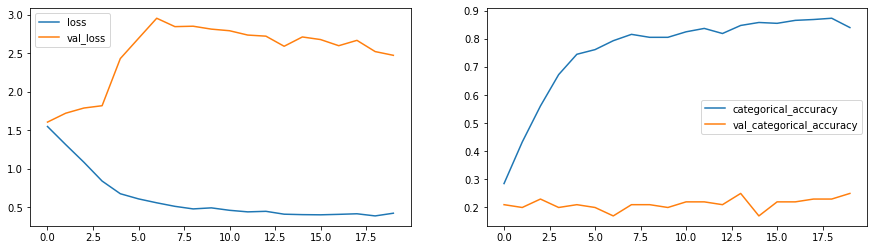

In [46]:
plot(history_modelLSTM)

# Model 3

Trying another model using CNN + LSTM

In [65]:
#write your model here
nb_featuremap = [16,32,64,128,256]
nb_dense = [128,64,5]
nb_classes = 5
# Input
input_shape=(frames,rows,cols,channel)

model1_LSTM = Sequential()

model1_LSTM.add(TimeDistributed(Conv2D(nb_featuremap[0], (3, 3), strides=(2, 2),activation='relu', padding='same'), input_shape=input_shape))
model1_LSTM.add(TimeDistributed(BatchNormalization()))
model1_LSTM.add(TimeDistributed(MaxPooling2D((2, 2), strides=(2, 2))))

model1_LSTM.add(TimeDistributed(Conv2D(nb_featuremap[1], (3,3),padding='same', activation='relu')))
model1_LSTM.add(TimeDistributed(BatchNormalization()))
model1_LSTM.add(TimeDistributed(MaxPooling2D((2, 2), strides=(2, 2))))

model1_LSTM.add(TimeDistributed(Conv2D(nb_featuremap[2], (3,3),padding='same', activation='relu')))
model1_LSTM.add(TimeDistributed(BatchNormalization()))
model1_LSTM.add(TimeDistributed(MaxPooling2D((2, 2), strides=(2, 2))))

model1_LSTM.add(TimeDistributed(Conv2D(nb_featuremap[3], (2,2),padding='same', activation='relu')))
model1_LSTM.add(TimeDistributed(BatchNormalization()))
model1_LSTM.add(TimeDistributed(MaxPooling2D((2, 2), strides=(2, 2))))

model1_LSTM.add(TimeDistributed(Conv2D(nb_featuremap[4], (2,2),padding='same', activation='relu')))
model1_LSTM.add(TimeDistributed(BatchNormalization()))
model1_LSTM.add(TimeDistributed(MaxPooling2D((2, 2), strides=(2, 2))))

model1_LSTM.add(TimeDistributed(Flatten()))

## using LSTM as the RNN model along with softmax as our last layer.
model1_LSTM.add(LSTM(64))
model1_LSTM.add(Dropout(0.25))
model1_LSTM.add(Dense(nb_dense[1], activation='relu'))
model1_LSTM.add(Dropout(0.25))

model1_LSTM.add(Dense(nb_classes, activation='softmax')) # using Softmax as last layer

from tensorflow.keras.optimizers import Adam

optimiser =Adam(0.001) #write your optimizer
model1_LSTM.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model1_LSTM.summary())

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_50 (TimeDi  (None, 10, 60, 60, 16)   448       
 stributed)                                                      
                                                                 
 time_distributed_51 (TimeDi  (None, 10, 60, 60, 16)   64        
 stributed)                                                      
                                                                 
 time_distributed_52 (TimeDi  (None, 10, 30, 30, 16)   0         
 stributed)                                                      
                                                                 
 time_distributed_53 (TimeDi  (None, 10, 30, 30, 32)   4640      
 stributed)                                                      
                                                                 
 time_distributed_54 (TimeDi  (None, 10, 30, 30, 32)  

The steps_per_epoch and validation_steps are used by fit_generator to decide the number of next() calls it need to make.
This time reducing batch size and increasing number of Epochs to 35

In [66]:
# creating the `train_generator` and the `val_generator` which will be used in `.fit_generator`
batch_size = 16
train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

num_epochs = 35

Let us now fit the model. This will start training the model and with the help of the checkpoints, you'll be able to save the model at the end of each epoch

In [67]:
history_model1LSTM = model1_LSTM.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: DeprecationWarning:     `imread` is deprecated!
    `imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
    Use ``imageio.imread`` instead.
  del sys.path[0]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: DeprecationWarning:     `imresize` is deprecated!
    `imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
    Use ``skimage.transform.resize`` instead.
  """


Source path =  app/Project_data/train ; batch size = 16
Epoch 1/35
41/42 [============================>.] - ETA: 0s - loss: 1.4771 - categorical_accuracy: 0.3506

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning:     `imread` is deprecated!
    `imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
    Use ``imageio.imread`` instead.


42/42 [==============================] - ETA: 0s - loss: 1.4759 - categorical_accuracy: 0.3514Source path =  app/Project_data/val ; batch size = 16

Epoch 00001: saving model to model_init_2022-01-2308_53_31.399787/model-00001-1.47587-0.35143-1.59835-0.27000.h5
42/42 [==============================] - 40s 933ms/step - loss: 1.4759 - categorical_accuracy: 0.3514 - val_loss: 1.5983 - val_categorical_accuracy: 0.2700 - lr: 0.0010
Epoch 2/35
42/42 [==============================] - ETA: 0s - loss: 1.2161 - categorical_accuracy: 0.5204
Epoch 00002: saving model to model_init_2022-01-2308_53_31.399787/model-00002-1.21613-0.52036-1.62051-0.22000.h5
42/42 [==============================] - 38s 933ms/step - loss: 1.2161 - categorical_accuracy: 0.5204 - val_loss: 1.6205 - val_categorical_accuracy: 0.2200 - lr: 0.0010
Epoch 3/35
42/42 [==============================] - ETA: 0s - loss: 1.0093 - categorical_accuracy: 0.6033
Epoch 00003: saving model to model_init_2022-01-2308_53_31.399787/model-000

Plotting 3rd variant of Model

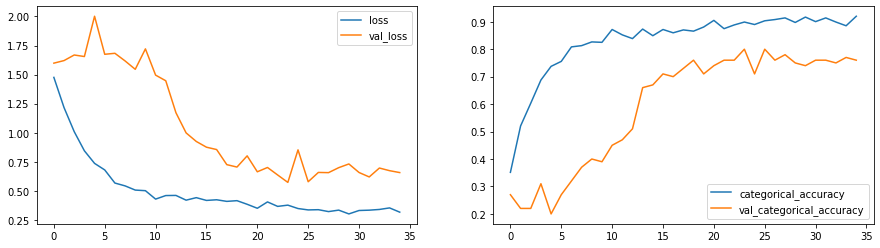

In [68]:
plot(history_model1LSTM)

# Model 4

Trying another model using CNN3D

In [69]:
#write your model here
nb_featuremap = [8,16,32,64]
nb_dense = [128,64,5]
nb_classes = 5
# Input
input_shape=(frames,rows,cols,channel)

model3d = Sequential()
model3d.add(Conv3D(nb_featuremap[0], 
                 kernel_size=(5,5,5),
                 input_shape=input_shape,
                 padding='same', name="conv1"))
model3d.add(Activation('relu'))
model3d.add(Conv3D(nb_featuremap[1], 
                 kernel_size=(3,3,3),
                 padding='same',name="conv2"))
model3d.add(Activation('relu'))
model3d.add(MaxPooling3D(pool_size=(2,2,2)))
model3d.add(Conv3D(nb_featuremap[2], 
                 kernel_size=(1,3,3), 
                 padding='same',name="conv3"))
model3d.add(Activation('relu'))
model3d.add(MaxPooling3D(pool_size=(2,2,2)))
model3d.add(BatchNormalization())
model3d.add(Dropout(0.25))
model3d.add(MaxPooling3D(pool_size=(2,2,2)))
model3d.add(Flatten())
model3d.add(Dense(nb_dense[0], activation='relu'))
model3d.add(Dropout(0.25))
model3d.add(Dense(nb_dense[1], activation='relu'))
#softmax layer
model3d.add(Dense(nb_dense[2], activation='softmax'))
optimiser = Adam(0.001)
model3d.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model3d.summary())





Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1 (Conv3D)              (None, 10, 120, 120, 8)   3008      
                                                                 
 activation (Activation)     (None, 10, 120, 120, 8)   0         
                                                                 
 conv2 (Conv3D)              (None, 10, 120, 120, 16)  3472      
                                                                 
 activation_1 (Activation)   (None, 10, 120, 120, 16)  0         
                                                                 
 max_pooling3d (MaxPooling3D  (None, 5, 60, 60, 16)    0         
 )                                                               
                                                                 
 conv3 (Conv3D)              (None, 5, 60, 60, 32)     4640      
                                                      

The steps_per_epoch and validation_steps are used by fit_generator to decide the number of next() calls it need to make.
This time keeping batch size to 32  and epochs to 30 as per original parameters

In [70]:
# creating the `train_generator` and the `val_generator` which will be used in `.fit_generator`
batch_size = 32
train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

num_epochs = 30

Let us now fit the model. This will start training the model and with the help of the checkpoints, you'll be able to save the model at the end of each epoch

In [71]:
history_model3d = model3d.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: DeprecationWarning:     `imread` is deprecated!
    `imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
    Use ``imageio.imread`` instead.
  del sys.path[0]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: DeprecationWarning:     `imresize` is deprecated!
    `imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
    Use ``skimage.transform.resize`` instead.
  """


Source path =  app/Project_data/train ; batch size = 32
Epoch 1/30
19/21 [==========================>...] - ETA: 2s - loss: 2.1374 - categorical_accuracy: 0.2253

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning:     `imread` is deprecated!
    `imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
    Use ``imageio.imread`` instead.


21/21 [==============================] - ETA: 0s - loss: 2.1035 - categorical_accuracy: 0.2262Source path =  app/Project_data/val ; batch size = 32

Epoch 00001: saving model to model_init_2022-01-2308_53_31.399787/model-00001-2.10345-0.22624-1.62557-0.21000.h5
21/21 [==============================] - 41s 2s/step - loss: 2.1035 - categorical_accuracy: 0.2262 - val_loss: 1.6256 - val_categorical_accuracy: 0.2100 - lr: 0.0010
Epoch 2/30
21/21 [==============================] - ETA: 0s - loss: 1.4355 - categorical_accuracy: 0.3997
Epoch 00002: saving model to model_init_2022-01-2308_53_31.399787/model-00002-1.43552-0.39970-1.59314-0.20000.h5
21/21 [==============================] - 40s 2s/step - loss: 1.4355 - categorical_accuracy: 0.3997 - val_loss: 1.5931 - val_categorical_accuracy: 0.2000 - lr: 0.0010
Epoch 3/30
21/21 [==============================] - ETA: 0s - loss: 1.2665 - categorical_accuracy: 0.4449
Epoch 00003: saving model to model_init_2022-01-2308_53_31.399787/model-00003-1.2

Plotting Model 4

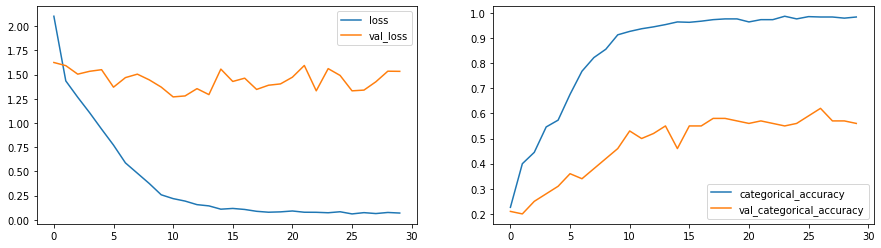

In [72]:
plot(history_model3d)

# Model 5

Trying another model using CNN3D by increasing Dense layers

In [77]:
#write your model here
nb_featuremap = [16,32,64,128]
nb_dense = [128,64,5]
nb_classes = 5
# Input
input_shape=(frames,rows,cols,channel)

model3d1 = Sequential()
model3d1.add(Conv3D(nb_featuremap[0], 
                 kernel_size=(3,3,3),
                 input_shape=input_shape,
                 padding='same', name="conv1"))
model3d1.add(Activation('relu'))


model3d1.add(Conv3D(nb_featuremap[1], 
                 kernel_size=(2,2,2),
                 padding='same',name="conv2"))
model3d1.add(Activation('relu'))
model3d1.add(BatchNormalization())
model3d1.add(MaxPooling3D(pool_size=(2,2,2)))

model3d1.add(Conv3D(nb_featuremap[2], 
                 kernel_size=(2,2,2), 
                 padding='same',name="conv3"))
model3d1.add(Activation('relu'))
model3d1.add(BatchNormalization())
model3d1.add(MaxPooling3D(pool_size=(2,2,2)))

model3d1.add(Conv3D(nb_featuremap[3], 
                 kernel_size=(2,2,2), 
                 padding='same',name="conv4"))
model3d1.add(Activation('relu'))
model3d1.add(BatchNormalization())
model3d1.add(MaxPooling3D(pool_size=(2,2,2)))

model3d1.add(Flatten())
model3d1.add(Dense(nb_dense[0], activation='relu'))
model3d1.add(BatchNormalization())
model3d1.add(Dropout(0.25))

model3d1.add(Dense(nb_dense[1], activation='relu'))
model3d1.add(BatchNormalization())
model3d1.add(Dropout(0.25))

#softmax layer
model3d1.add(Dense(nb_dense[2], activation='softmax'))
optimiser = Adam(0.0002)
model3d1.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model3d1.summary())

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1 (Conv3D)              (None, 10, 120, 120, 16)  1312      
                                                                 
 activation_19 (Activation)  (None, 10, 120, 120, 16)  0         
                                                                 
 conv2 (Conv3D)              (None, 10, 120, 120, 32)  4128      
                                                                 
 activation_20 (Activation)  (None, 10, 120, 120, 32)  0         
                                                                 
 batch_normalization_34 (Bat  (None, 10, 120, 120, 32)  128      
 chNormalization)                                                
                                                                 
 max_pooling3d_19 (MaxPoolin  (None, 5, 60, 60, 32)    0         
 g3D)                                                

The steps_per_epoch and validation_steps are used by fit_generator to decide the number of next() calls it need to make

In [78]:
# creating the `train_generator` and the `val_generator` which will be used in `.fit_generator`
batch_size = 32
train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

num_epochs = 30

Let us now fit the model. This will start training the model and with the help of the checkpoints, you'll be able to save the model at the end of each epoch

In [79]:
history_model3d1 = model3d1.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: DeprecationWarning:     `imread` is deprecated!
    `imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
    Use ``imageio.imread`` instead.
  del sys.path[0]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: DeprecationWarning:     `imresize` is deprecated!
    `imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
    Use ``skimage.transform.resize`` instead.
  """


Source path =  app/Project_data/train ; batch size = 32
Epoch 1/30
19/21 [==========================>...] - ETA: 3s - loss: 1.6505 - categorical_accuracy: 0.4194

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning:     `imread` is deprecated!
    `imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
    Use ``imageio.imread`` instead.


21/21 [==============================] - ETA: 0s - loss: 1.6277 - categorical_accuracy: 0.4178Source path =  app/Project_data/val ; batch size = 32

Epoch 00001: saving model to model_init_2022-01-2308_53_31.399787/model-00001-1.62768-0.41780-1.86569-0.21000.h5
21/21 [==============================] - 43s 2s/step - loss: 1.6277 - categorical_accuracy: 0.4178 - val_loss: 1.8657 - val_categorical_accuracy: 0.2100 - lr: 2.0000e-04
Epoch 2/30
21/21 [==============================] - ETA: 0s - loss: 0.8074 - categorical_accuracy: 0.6833
Epoch 00002: saving model to model_init_2022-01-2308_53_31.399787/model-00002-0.80738-0.68326-3.48117-0.20000.h5
21/21 [==============================] - 40s 2s/step - loss: 0.8074 - categorical_accuracy: 0.6833 - val_loss: 3.4812 - val_categorical_accuracy: 0.2000 - lr: 2.0000e-04
Epoch 3/30
21/21 [==============================] - ETA: 0s - loss: 0.5305 - categorical_accuracy: 0.8145
Epoch 00003: saving model to model_init_2022-01-2308_53_31.399787/model-0

Plotting Model #5

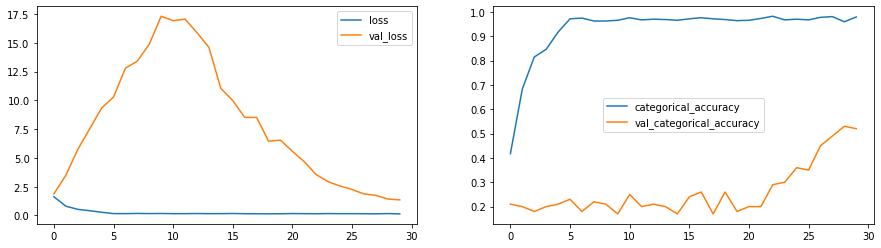

In [80]:
plot(history_model3d1)

# Model 6

Trying another model using CNN3D by train the model to make it Batch Size = 16 and No. of Epochs = 20


In [81]:
# creating the `train_generator` and the `val_generator` which will be used in `.fit_generator`
batch_size = 16
train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

num_epochs = 20


Let us now fit the model. This will start training the model and with the help of the checkpoints, you'll be able to save the model at the end of each epoch

In [82]:
history_model3d2 = model3d.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: DeprecationWarning:     `imread` is deprecated!
    `imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
    Use ``imageio.imread`` instead.
  del sys.path[0]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: DeprecationWarning:     `imresize` is deprecated!
    `imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
    Use ``skimage.transform.resize`` instead.
  """


Source path =  app/Project_data/train ; batch size = 16
Epoch 1/20
41/42 [============================>.] - ETA: 0s - loss: 0.0741 - categorical_accuracy: 0.9848

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning:     `imread` is deprecated!
    `imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
    Use ``imageio.imread`` instead.


42/42 [==============================] - ETA: 0s - loss: 0.0735 - categorical_accuracy: 0.9849Source path =  app/Project_data/val ; batch size = 16

Epoch 00001: saving model to model_init_2022-01-2308_53_31.399787/model-00001-0.07351-0.98492-1.56452-0.57000.h5
42/42 [==============================] - 41s 967ms/step - loss: 0.0735 - categorical_accuracy: 0.9849 - val_loss: 1.5645 - val_categorical_accuracy: 0.5700 - lr: 1.0000e-07
Epoch 2/20
42/42 [==============================] - ETA: 0s - loss: 0.0814 - categorical_accuracy: 0.9744
Epoch 00002: saving model to model_init_2022-01-2308_53_31.399787/model-00002-0.08142-0.97436-1.50674-0.60000.h5
42/42 [==============================] - 40s 959ms/step - loss: 0.0814 - categorical_accuracy: 0.9744 - val_loss: 1.5067 - val_categorical_accuracy: 0.6000 - lr: 1.0000e-07
Epoch 3/20
42/42 [==============================] - ETA: 0s - loss: 0.0805 - categorical_accuracy: 0.9759
Epoch 00003: saving model to model_init_2022-01-2308_53_31.399787/m

Plot # Model6

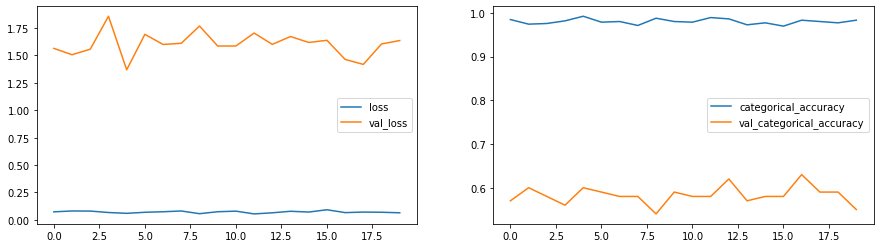

In [83]:
plot(history_model3d2)